This notebook applies hierarchical bayesian modeling using topographical remote sensing product

In [46]:
%load_ext autoreload
%autoreload 2

In [48]:
import sys
sys.path.append('..')
import pymc3 as pm
from tqdm import tqdm
from sklearn.metrics import *

import optuna
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.model_selection import train_test_split

from src.utils import *
from src.params import *
tqdm.pandas()

%matplotlib inline

# Data Pre-Processing

In [2]:
df, basin_idx, basins, coords = read_data(file_dir='../data/hierarchical_septics_v2.csv',
        cols=['ppt_2013', 'water_dist', 'hydraulic_c','median_hse', 'dem', 'flow'], is_balanced=True)

balancing...
repairs: 7.6567198704603285%, non-repairs: 92.34328012953968%
processing soil hydraulic data...
acquiring housing information...
processing DEM and flow information...


# Baseline Comparison

In [3]:
train_x, test_x, train_y, test_y = train_test_split(df[['water_dist_norm', 'ppt_2013_norm', 'hydraulic_c_norm', 'median_hse_norm', 'flow_norm', 'dem_norm']], 
                                                    df['sewageSystem_enc'], 
                                                    test_size=0.1, 
                                                    random_state=42)

### a) Aggregate Bayesian

\begin{equation*}
Y \sim Bernoulli(\theta)\tag{1}
\end{equation*}

\begin{equation*}
\theta = \sigma(\beta_{c} + \beta_{w}.waterdist + \beta_{p}.precip + \beta_{h}.hydraulics + \beta_{s}.hseval + \beta_{t}.elev) \tag{2}
\end{equation*}

\begin{equation*}
\textbf{Intercept parameters}\\
    \beta_{c} \sim N_{c}(\mu=\mu_{c}, \sigma=\theta_{c})\\
    \text{where }\mu_{c} \sim N(\mu=0, \sigma=10) \quad and \quad \theta_{c} \sim HN(\sigma=10) \tag{3}
\end{equation*}

\begin{equation*}
\textbf{Precipitation parameters}\\
    \beta_{p} \sim N_{p}(\mu=\mu_{p}, \sigma=\sigma_p)\\
    \text{where }\mu_{p} \sim N(\mu=0, \sigma=10) \quad and \quad \sigma_p \sim HN(\sigma=10) \tag{4}
\end{equation*}

\begin{equation*}
\textbf{Soil hydraulic conductivity parameters}\\
    \beta_{h} \sim U_{h}(lower=-2,upper=\sigma_h)\\
    \text{where }\sigma_h \sim HN(\sigma=10) \tag{5}
\end{equation*}

\begin{equation*}
\textbf{Socio-economic parameters}\\
    \beta_{s} \sim N_{s}(\mu=0, \sigma=\sigma_s)\\
    \text{where }\sigma_s \sim HN(\sigma=5) \tag{6}
\end{equation*}

\begin{equation*}
\textbf{Topography (elevation) parameters}\\
    \beta_{t} \sim Exp_{t}(\lambda=\lambda_t)\\
    \text{where }\lambda_t \sim HN(\sigma=5) \tag{7}
\end{equation*}

In [31]:
rs = 57
tune = 350

1. Water model: precipitation and distance to water bodies

In [ ]:
with pm.Model(coords=coords) as model:
    print('fitting full pooled Bayesian model...')
    # constant data: basin information and variables
    basin = pm.Data('basin', basin_idx)
    water_d = pm.Data('water_d', df.water_dist_norm.values)
    ppt_d = pm.Data('ppt_d', df.ppt_2013_norm.values)

    # global model parameters
    wtr_beta = pm.HalfNormal("wtr_beta", sigma=10)
    ppt_mu = pm.Normal("ppt_mu", mu=0, sigma=10)
    ppt_sig = pm.HalfNormal("ppt_sig", sigma=10)
    mu_c = pm.Normal('mu_c', mu=0, sigma=10)
    sigma_c = pm.HalfNormal('sigma_c', sigma=10)

    # septic-specific model parameters
    wtr_dist = pm.Exponential("wtr_dist", lam=wtr_beta)
    ppt = pm.Normal("ppt", mu=ppt_mu, sigma=ppt_sig)
    c = pm.Normal('c', mu=mu_c, sigma=sigma_c)
    
    # hierarchical bayesian formula
    failure_theta = pm.math.sigmoid(c
                                    + wtr_dist * water_d 
                                    + ppt * ppt_d
                                   )

    # likelihood of observed data
    priors = pm.sample_prior_predictive(samples=500)
    failures = pm.Bernoulli('failures', failure_theta, observed=df['sewageSystem_enc'])
    
    # fitting using NUTS sampler
    trace = pm.sample(500, tune=tune, cores=4, return_inferencedata=True, target_accept=0.99, random_seed=rs)

In [33]:
# evaluate baseline bayesian
y = df.sewageSystem_enc.to_list()
acc, y_pred = evaluate_bayes(trace, model, y)
print(f'accuracy is: {acc}%')

/Users/juannat/opt/anaconda3/envs/septic/lib/python3.9/site-packages/pymc3/sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


accuracy is: 52.17391304347826%


2. Topo model: soil hydraulics and elevation

In [ ]:
with pm.Model(coords=coords) as model:
    print('fitting full pooled Bayesian model...')
    # constant data: basin information and variables
    basin = pm.Data('basin', basin_idx)
    hydr_d = pm.Data('hydr_d', df.hydraulic_c_norm.values)
    dem_d = pm.Data('dem_d', df.dem_norm.values)

    # global model parameters
    hydr_sig = pm.HalfNormal('hydr_sig', sigma=10)
    dem_beta = pm.HalfNormal('dem_beta', sigma=5)
    mu_c = pm.Normal('mu_c', mu=0, sigma=10)
    sigma_c = pm.HalfNormal('sigma_c', sigma=10)

    # septic-specific model parameters
    hydr = pm.Uniform('hydr', lower=-2, upper=hydr_sig)
    dem = pm.Exponential('dem', lam=dem_beta)
    c = pm.Normal('c', mu=mu_c, sigma=sigma_c)
    
    # hierarchical bayesian formula
    failure_theta = pm.math.sigmoid(c
                                    + hydr * hydr_d
                                    + dem * dem_d
                                   )

    # likelihood of observed data
    priors = pm.sample_prior_predictive(samples=500)
    failures = pm.Bernoulli('failures', failure_theta, observed=df['sewageSystem_enc'])
    
    # fitting using NUTS sampler
    trace = pm.sample(500, tune=tune, cores=4, return_inferencedata=True, target_accept=0.99, random_seed=rs)

In [35]:
# evaluate baseline bayesian
y = df.sewageSystem_enc.to_list()
acc, y_pred = evaluate_bayes(trace, model, y)
print(f'accuracy is: {acc}%')

/Users/juannat/opt/anaconda3/envs/septic/lib/python3.9/site-packages/pymc3/sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


accuracy is: 53.57142857142857%


3. Socio-economic model: median housing value

In [ ]:
with pm.Model(coords=coords) as model:
    print('fitting full pooled Bayesian model...')
    # constant data: basin information and variables
    basin = pm.Data('basin', basin_idx)
    hse_d = pm.Data('hse_d', df.median_hse_norm.values)

    # global model parameters
    hse_sig = pm.HalfNormal('hse_sig', sigma=5)
    mu_c = pm.Normal('mu_c', mu=0, sigma=10)
    sigma_c = pm.HalfNormal('sigma_c', sigma=10)

    # septic-specific model parameters
    hse = pm.Normal('hse', mu=0, sigma=hse_sig)
    c = pm.Normal('c', mu=mu_c, sigma=sigma_c)
    
    # hierarchical bayesian formula
    failure_theta = pm.math.sigmoid(c
                                    + hse * hse_d
                                   )

    # likelihood of observed data
    priors = pm.sample_prior_predictive(samples=500)
    failures = pm.Bernoulli('failures', failure_theta, observed=df['sewageSystem_enc'])
    
    # fitting using NUTS sampler
    trace = pm.sample(500, tune=tune, cores=4, return_inferencedata=True, target_accept=0.95, random_seed=rs)

In [45]:
# evaluate baseline bayesian
y = df.sewageSystem_enc.to_list()
acc, y_pred = evaluate_bayes(trace, model, y)
print(f'accuracy is: {acc}%')

/Users/juannat/opt/anaconda3/envs/septic/lib/python3.9/site-packages/pymc3/sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


accuracy is: 59.62732919254658%


4. Full model

In [ ]:
with pm.Model(coords=coords) as model:
    print('fitting full pooled Bayesian model...')
    # constant data: basin information and variables
    basin = pm.Data('basin', basin_idx)
    water_d = pm.Data('water_d', df.water_dist_norm.values)
    ppt_d = pm.Data('ppt_d', df.ppt_2013_norm.values)
    hydr_d = pm.Data('hydr_d', df.hydraulic_c_norm.values)
    hse_d = pm.Data('hse_d', df.median_hse_norm.values)
    dem_d = pm.Data('dem_d', df.dem_norm.values)

    # global model parameters
    wtr_beta = pm.HalfNormal("wtr_beta", sigma=10)
    ppt_mu = pm.Normal("ppt_mu", mu=0, sigma=10)
    ppt_sig = pm.HalfNormal("ppt_sig", sigma=10)
    hydr_sig = pm.HalfNormal('hydr_sig', sigma=10)
    hse_sig = pm.HalfNormal('hse_sig', sigma=5)
    dem_beta = pm.HalfNormal('dem_beta', sigma=5)
    mu_c = pm.Normal('mu_c', mu=0, sigma=10)
    sigma_c = pm.HalfNormal('sigma_c', sigma=10)

    # septic-specific model parameters
    wtr_dist = pm.Exponential("wtr_dist", lam=wtr_beta)
    ppt = pm.Normal("ppt", mu=ppt_mu, sigma=ppt_sig)
    hydr = pm.Uniform('hydr', lower=-2, upper=hydr_sig)
    hse = pm.Normal('hse', mu=0, sigma=hse_sig)
    dem = pm.Exponential('dem', lam=dem_beta)
    c = pm.Normal('c', mu=mu_c, sigma=sigma_c)
    
    # hierarchical bayesian formula
    failure_theta = pm.math.sigmoid(c
                                    + wtr_dist * water_d 
                                    + ppt * ppt_d
                                    + hydr * hydr_d
                                    + hse * hse_d
                                    + dem * dem_d
                                   )

    # likelihood of observed data
    priors = pm.sample_prior_predictive(samples=500)
    failures = pm.Bernoulli('failures', failure_theta, observed=df['sewageSystem_enc'])
    
    # fitting using NUTS sampler
    trace = pm.sample(500, tune=tune, cores=4, return_inferencedata=True, target_accept=0.99, random_seed=rs)

In [43]:
# evaluate baseline bayesian
y = df.sewageSystem_enc.to_list()
acc, y_pred = evaluate_bayes(trace, model, y)
print(f'accuracy is: {acc}%')

/Users/juannat/opt/anaconda3/envs/septic/lib/python3.9/site-packages/pymc3/sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


accuracy is: 60.24844720496895%


In [6]:
graph = pm.model_graph.model_to_graphviz(model)
graph.render(filename='../docs/pooled')

'../docs/pooled.pdf'

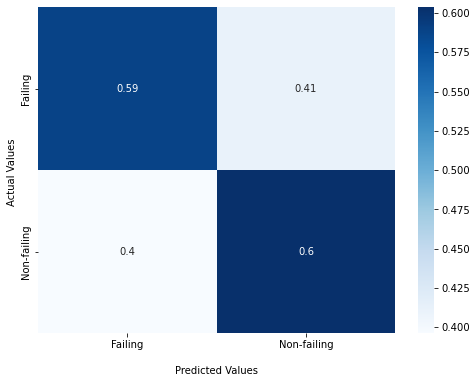

In [54]:
plot_confusion(y, y_pred, title='', savedir='../docs/confusion_l0.pdf')

## Hyperparameter Optimization

In [9]:
# hyperparameter optimization with optuna
def objective(trial, classifier_name):
    assert classifier_name in ['SVC', 'RF', 'XGB', 'GBDT']
    if classifier_name == 'SVC':
        svc_deg = trial.suggest_int('svc_deg', 1, 10)
        svc_c = trial.suggest
        classifier_obj = SVC(degree=svc_deg, gamma='auto')
        
    elif classifier_name == 'RF':
        rf_n_estimators = trial.suggest_int('n_estimators', 100, 1000)
        classifier_obj = RandomForestClassifier(n_estimators=rf_n_estimators)
    
    elif classifier_name == 'XGB':
        xgb_eta = trial.suggest_float('xgb_eta', 0., 1.)
        xgb_max_depth = trial.suggest_int('xgb_max_depth', 1, 20)
        classifier_obj = xgb.XGBClassifier(eta=xgb_eta, max_depth=xgb_max_depth,
                                           enable_categorical=True, use_label_encoder=False)
        
    else:
        gbdt_n_estimators = trial.suggest_int('gbdt_n_estimators', 100, 1000)
        gbdt_lr = trial.suggest_float('gbdt_lr', 0.01, 1.)
        classifier_obj = lgb.LGBMClassifier(n_estimators=gbdt_n_estimators, learning_rate=gbdt_lr)
        
    score = sklearn.model_selection.cross_val_score(classifier_obj, train_x, train_y, n_jobs=-1, cv=3)
    accuracy = score.mean()
    return accuracy

In [ ]:
# Optimize SVC
study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: objective(trial, classifier_name='SVC'), n_trials=10)

In [ ]:
# Optimize RF
study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: objective(trial, classifier_name='RF'), n_trials=100)

In [ ]:
# Optimize XGB
study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: objective(trial, classifier_name='XGB'), n_trials=100)

In [ ]:
# Optimize GBDT
study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: objective(trial, classifier_name='GBDT'), n_trials=100)

## Optimized Baseline Analysis

### b) Random Forest

accuracy for random forest: 66.15384615384615%


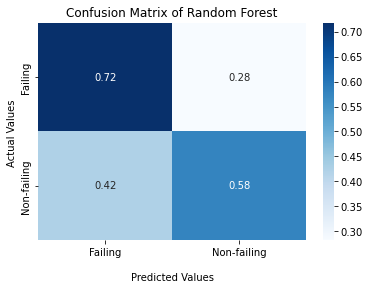

In [16]:
# Random Forest
rf_clf = RandomForestClassifier(n_estimators=98)
rf_clf.fit(train_x, train_y)
rf_y_pred = rf_clf.predict(test_x)
acc = rf_clf.score(test_x, test_y)
print(f'accuracy for random forest: {acc * 100}%')

plot_confusion(test_y, rf_y_pred, title='Confusion Matrix of Random Forest')

### c) SVC

accuracy for SVC: 67.6923076923077%


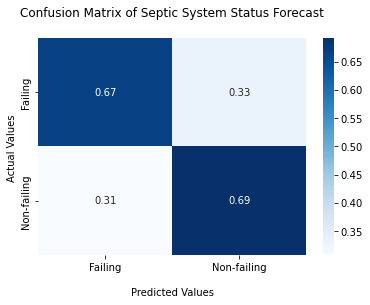

In [12]:
# SVC
svc_clf = SVC(degree=3)
svc_clf.fit(train_x, train_y)
acc = svc_clf.score(test_x, test_y)
svc_y_pred = svc_clf.predict(test_x)
print(f'accuracy for SVC: {acc * 100}%')

plot_confusion(test_y, svc_y_pred)

### d) XGBoost

[23:09:08] WARNING: ../src/learner.cc:573: 
Parameters: { "enable_categorical" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:09:08] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
accuracy for XGBoost: 67.6923076923077%


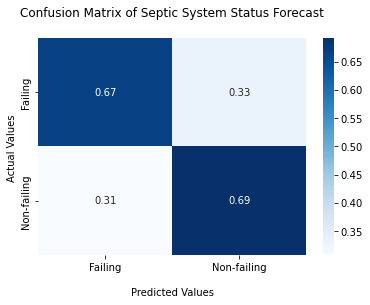

In [14]:
# XGBoost
xgb_clf = xgb.XGBClassifier(
    eta=0.03875457352141243, max_depth=12, enable_categorical=True, use_label_encoder=False
)

xgb_clf.fit(train_x, train_y)
acc = xgb_clf.score(test_x, test_y)
xgb_y_pred = xgb_clf.predict(test_x)
print(f'accuracy for XGBoost: {acc * 100}%')

plot_confusion(test_y, xgb_y_pred)

### e) Gradient Boosting Decision Tree (GBDT)

accuracy for GBDT: 73.84615384615385%


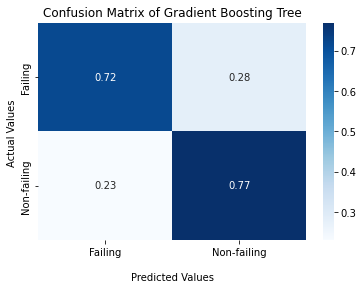

In [15]:
# LightGBM
gbdt_clf = lgb.LGBMClassifier(n_estimators=302, learning_rate=0.011684687770816824)
gbdt_clf.fit(train_x, train_y)
acc = gbdt_clf.score(test_x, test_y)
gbdt_y_pred = gbdt_clf.predict(test_x)
print(f'accuracy for GBDT: {acc * 100}%')

plot_confusion(test_y, gbdt_y_pred, title='Confusion Matrix of Gradient Boosting Tree')